## Import libraries

In [4]:
accesibilidad_urbana = '../../'

In [62]:
import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.ops import nearest_points
from shapely.geometry import Point,LineString
from shapely.geometry import GeometryCollection

from shapely.ops import split
import time

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [52]:
# Projection to be used whenever necessary
projected_crs = 'EPSG:32719'

## Strategy 1 - Find nearest point from one gdf to point of another gdf keeping IDs

### Create data

In [53]:
d = {'point_id': ['Juárez', 'Allende','Aldama','Carranza'], 
     'geometry': [Point(21, 2.4), Point(31, 2.4), Point(41, 2.4), Point(51, 2.4)]}
local_network = gpd.GeoDataFrame(d, crs=projected_crs)
local_network

,point_id,geometry
0,Juárez,POINT (21.000 2.400)
1,Allende,POINT (31.000 2.400)
2,Aldama,POINT (41.000 2.400)
3,Carranza,POINT (51.000 2.400)


In [54]:
d = {'street_id': ['osmid1', 'osmid1','osmid1','osmid1','osmid1',
                  'osmid2', 'osmid2','osmid2','osmid2','osmid2'], 
     'geometry': [Point(25,0),Point(35,0),Point(45,0),Point(55,0),Point(65,0),
                 Point(35,-5),Point(35,0),Point(35,5),Point(35,10),Point(35,15)]}
osmnx_network = gpd.GeoDataFrame(d, crs=projected_crs)
osmnx_network

,street_id,geometry
0,osmid1,POINT (25.000 0.000)
1,osmid1,POINT (35.000 0.000)
2,osmid1,POINT (45.000 0.000)
3,osmid1,POINT (55.000 0.000)
4,osmid1,POINT (65.000 0.000)
5,osmid2,POINT (35.000 -5.000)
6,osmid2,POINT (35.000 0.000)
7,osmid2,POINT (35.000 5.000)
8,osmid2,POINT (35.000 10.000)
9,osmid2,POINT (35.000 15.000)


<Axes: >

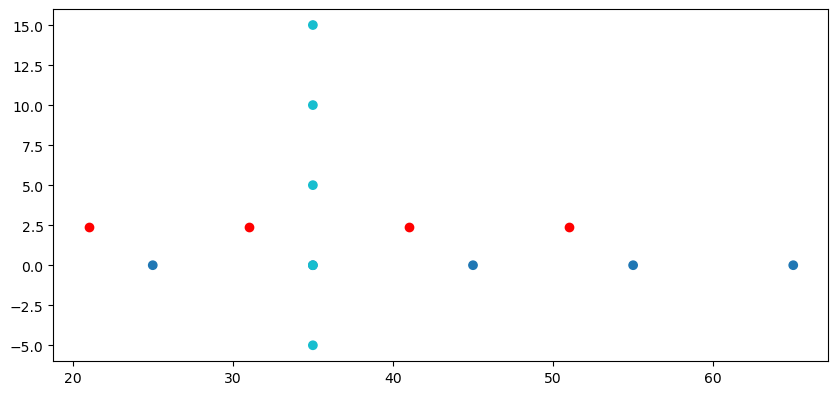

In [55]:
fig,ax = plt.subplots(figsize=(10,10))
local_network.plot(ax=ax,color='red')
osmnx_network.plot('street_id',ax=ax)

In [56]:
# Eliminar duplicados geométricos en ambos gdfs
print(len(local_network))
print(len(osmnx_network))
calles_gdf = local_network.drop_duplicates(subset='geometry')
target_gdf = osmnx_network.drop_duplicates(subset='geometry')
print(len(calles_gdf))
print(len(target_gdf))

4
10
4
9


### Find nearest

In [57]:
# Función para encontrar el punto más cercano de target_gdf para un punto dado
def nearest(row, other_gdf, geom_col='geometry', src_geom_col='geometry'):
    # Encuentra el punto más cercano a 'row' en 'other_gdf'
    nearest_geom = nearest_points(row[geom_col], other_gdf.unary_union)[1]
    # Encuentra la fila completa en 'other_gdf' que tiene esa geometría
    nearest_row = other_gdf.loc[other_gdf[geom_col] == nearest_geom]
    return nearest_row.iloc[0]

# Aplicar la función para encontrar el punto más cercano para cada punto en calles_gdf
nearest_nodes =calles_gdf.apply(nearest, other_gdf=target_gdf, axis=1)
calles_nearest = calles_gdf.copy()
calles_nearest['nearest_st'] = nearest_nodes['street_id']
calles_nearest['nearest_geom'] = nearest_nodes['geometry']

# Calcular la distancia al punto más cercano
calles_nearest['distance_to_nearest'] = calles_nearest.distance(calles_nearest['nearest_geom'])

calles_nearest

,point_id,geometry,nearest_st,nearest_geom,distance_to_nearest
0,Juárez,POINT (21.000 2.400),osmid1,POINT (25.000 0.000),4.664762
1,Allende,POINT (31.000 2.400),osmid1,POINT (35.000 0.000),4.664762
2,Aldama,POINT (41.000 2.400),osmid1,POINT (45.000 0.000),4.664762
3,Carranza,POINT (51.000 2.400),osmid1,POINT (55.000 0.000),4.664762


## Strategy 2 - Most similar geometry to another line (Hausdorff, Frechet)

### __Strategy 2__ - Simple test

In [150]:
d = {'street_id': ['Juárez','Aldama'], 
     'geometry': [LineString([(21, 2.4),(51, 2.4)]),LineString([(30, -5),(30, 15)])]}
local_network = gpd.GeoDataFrame(d, crs=projected_crs)
local_network

,street_id,geometry
0,Juárez,"LINESTRING (21.000 2.400, 51.000 2.400)"
1,Aldama,"LINESTRING (30.000 -5.000, 30.000 15.000)"


In [167]:
d = {'osmid_id': ['osmid3','osmid2','osmid1'], 
     'geometry': [LineString([(20, 2.75),(50, 2.75)]),LineString([(20, 0),(50, 0)]),LineString([(35, -5),(35, 15)])]}
osmnx_network = gpd.GeoDataFrame(d, crs=projected_crs)
osmnx_network

,osmid_id,geometry
0,osmid3,"LINESTRING (20.000 2.750, 50.000 2.750)"
1,osmid2,"LINESTRING (20.000 0.000, 50.000 0.000)"
2,osmid1,"LINESTRING (35.000 -5.000, 35.000 15.000)"


<Axes: >

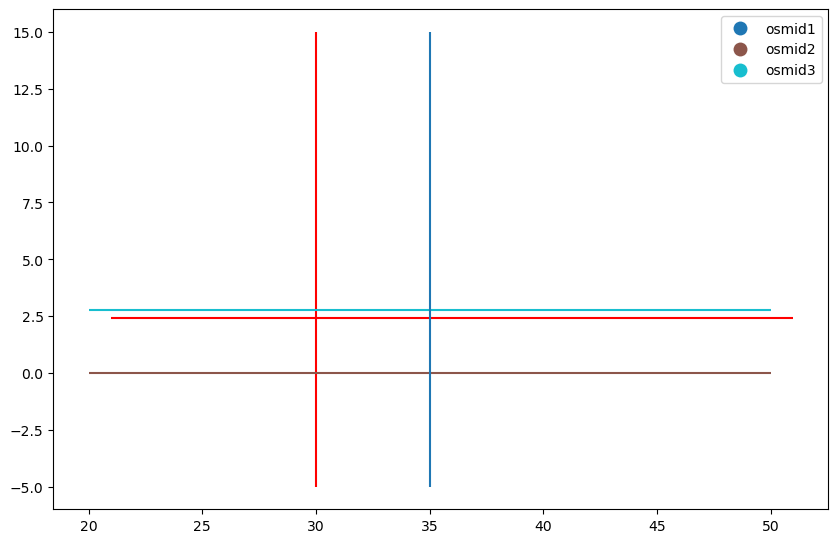

In [180]:
fig,ax = plt.subplots(figsize=(10,10))
local_network.plot(ax=ax,color='red')
osmnx_network.plot('osmid_id',ax=ax,legend=True)

In [177]:
original_network = local_network.copy()
target_network = osmnx_network.copy()

from shapely import hausdorff_distance, frechet_distance

# Crear una función para encontrar la línea más cercana en términos de Hausdorff
def nearest_line(row, other_gdf):
    min_distance = float('inf')
    nearest_line = None
    
    for _, target_row in other_gdf.iterrows():
        print(row['street_id'])
        distance = row['geometry'].hausdorff_distance(target_row['geometry'])
        print(distance)

        # If currently measured distance is less than registered min_distance, register
        if distance < min_distance:
            min_distance = distance
            nearest_line = target_row['osmid_id']
            print(nearest_line)
    
    print(f'Winner:{nearest_line}')
    print('----Next street-----')
    
    return nearest_line

# Aplicar la función para encontrar la línea más cercana para cada línea en original_network
original_network['nearest_line'] = original_network.apply(nearest_line, other_gdf=target_network, axis=1)
original_network

Juárez
1.0594810050208545
osmid3
Juárez
2.6
Juárez
16.0
Winner:osmid3
----Next street-----
Aldama
20.0
osmid3
Aldama
20.0
Aldama
5.0
osmid1
Winner:osmid1
----Next street-----


,street_id,geometry,nearest_line
0,Juárez,"LINESTRING (21.000 2.400, 51.000 2.400)",osmid3
1,Aldama,"LINESTRING (30.000 -5.000, 30.000 15.000)",osmid1


### __Strategy 2__ - Real test

In [219]:
gral_dir = accesibilidad_urbana+"data/external/specific-network_transfer/"
gral_dir

'../../data/external/specific-network_transfer/'

In [220]:
# 1.0 --------------- LOAD DATA
# ------------------- Load local network
# Load data
local_network = gpd.read_file(gral_dir+"test_area_local_streets_32719.gpkg")
# Set CRS
if local_network.crs != projected_crs:
    try:
        local_network = local_network.set_crs(projected_crs)
    except:
        local_network = local_network.to_crs(projected_crs)

# Filter data
local_network = local_network[['IDcllbf','pje_ep','geometry']]
local_network.rename(columns={'IDcllbf':'street_id'},inplace=True)

# Show
print(local_network.shape)
local_network.head(2)

(338, 3)


,street_id,pje_ep,geometry
0,150.0,0.261844,"MULTILINESTRING ((336866.602 6296306.973, 3369..."
1,152.0,0.130970,"MULTILINESTRING ((336776.728 6296302.353, 3367..."


In [221]:
# 1.0 --------------- LOAD DATA
# ------------------- Load OSMnx network
# Load data
osmnx_network = gpd.read_file(gral_dir+"test_area_osmnx_edges_32719.gpkg")
# Set CRS
if osmnx_network.crs != projected_crs:
    try:
        osmnx_network = osmnx_network.set_crs(projected_crs)
    except:
        osmnx_network = osmnx_network.to_crs(projected_crs)

# Show
print(osmnx_network.shape)
osmnx_network.head(2)

(672, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,443198326,443198676,0,484811205,False,2,Isla Grande de Tierra del Fuego,tertiary,None,146.940,None,None,None,None,None,None,None,"MULTILINESTRING ((336402.936 6296515.282, 3364..."
1,443198341,9102377120,0,213285792,True,2,Avenida La Laguna Sur,secondary,None,101.142,None,None,None,None,None,None,None,"MULTILINESTRING ((336398.321 6296484.718, 3364..."


### Approach 1: Function applied to local_network

In [254]:
# Create unique ID for each OSMnx edge using u and v
target_network = osmnx_network.copy()
target_network['u'] = target_network['u'].astype('str')
target_network['v'] = target_network['v'] .astype('str')
target_network['osmnx_id']= target_network['u']+ target_network['v']

# Copy local network
original_network = local_network.copy()

# Find nearest line to each line using Hausdorff distance
def nearest_line(row, other_gdf):
    # For each row(line), set min_distance found to infinite
    min_distance = float('inf')
    nearest_line = None

    # For each row(line) in the target_gdf (OSMnx network), iterate and find distance to current line
    for _, target_row in other_gdf.iterrows():
        distance = row['geometry'].hausdorff_distance(target_row['geometry'])

        # If currently measured distance is less than registered min_distance, rewrite min_distance and nearest_line
        if distance < min_distance:
            min_distance = distance
            nearest_line = target_row['osmnx_id']
            #print(f"Found closer line for idx {row['street_id']} at distance {distance}. Close line: {nearest_line}")

    # Finally, register result
    row['nearest_line'] = nearest_line
    row['min_distance'] = min_distance
    
    return row

# Apply nearest_line() function to find closest line to each line in original network
#original_network['nearest_line'], original_network['min_distance'] = original_network.apply(nearest_line, other_gdf=target_network, axis=1)
original_network = original_network.apply(nearest_line, other_gdf=target_network, axis=1)

# Show
print(original_network.shape)
original_network.head(1)

(338, 5)


,street_id,pje_ep,geometry,nearest_line,min_distance
0,150.0,0.261844,"MULTILINESTRING ((336866.602 6296306.973, 3369...",443960579443960768,3.154251


In [265]:
# Find duplicated nearest lines (Occurs when two or more original network lines get assigned to the same OSMnx network line)
duplicated_nearest_lines = original_network.loc[original_network.duplicated(subset='nearest_line', keep=False)]
# For each duplicated nearest line, keep the row with the lowest 'min_distance' (The most similar according to hausdorff_distance result)
idx_min = duplicated_nearest_lines.groupby('nearest_line')['min_distance'].idxmin()
# Filter selected rows
filtered_duplicates = duplicated_nearest_lines.loc[idx_min]

# Remove those duplicated lines from the resulting network
filtered_network = original_network.copy()
filtered_network = filtered_network.drop_duplicates(subset='nearest_line',keep=False)
# Append filtered duplicates
filtered_network = pd.concat([filtered_network,filtered_duplicates])

# Show
print(f"Uniquely assigned OSMnx lines to original lines gdf: {len(resulting_network.nearest_line.unique())}.")
print(filtered_network.shape)
filtered_network.head(1)

Uniquely assigned OSMnx lines to original lines gdf: 301.
(301, 5)


,street_id,pje_ep,geometry,nearest_line,min_distance
0,150.0,0.261844,"MULTILINESTRING ((336866.602 6296306.973, 3369...",443960579443960768,3.154251


In [266]:
# CHECK RESULT IN QGIS
duplicated_nearest_lines.to_file(gral_dir + "duplicated_nearest_lines.gpkg", driver='GPKG')
filtered_network.to_file(gral_dir + "filtered_network.gpkg", driver='GPKG')

In [267]:
# Merge street_id and columns of interest back to osmnx network
resulting_network = pd.merge(target_network,filtered_network[['street_id','pje_ep','nearest_line']],
                             left_on='osmnx_id',right_on='nearest_line')
resulting_network.drop(columns=['nearest_line'],inplace=True)

# Show
print(resulting_network.shape)
resulting_network.head(1)

(301, 21)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,...,ref,junction,tunnel,access,width,service,geometry,osmnx_id,street_id,pje_ep
0,443198326,443198676,0,484811205,False,2,Isla Grande de Tierra del Fuego,tertiary,None,146.94,...,None,None,None,None,None,None,"MULTILINESTRING ((336402.936 6296515.282, 3364...",443198326443198676,19412.0,0.873692


In [268]:
resulting_network.to_file(gral_dir + "resulting_network_filtered.gpkg", driver='GPKG')

In [ ]:
# Problema de duplicados en la original network:
# Ocurre cuando una línea de la red original tiene como correspondiente dos (o más) líneas más pequeñas de OSMnx.
# Hausdorff, en lugar de asignarle una de las dos (o más) líneas, asigna la paralela más cercana. Esa paralela, aparte tendrá su línea original correspondiente.
# Posible solución: Antes de asignar la línea a la row, guardar en un gdf la línea original, la distancia Hausdorff y el osmnx_id que se está guardando.
# Para las siguientes líneas, si una línea se quiere asignar a un osmnx_id que ya está guardado, buscar la línea original que se había guardado y comparar las distancias Hausdorff.
# Mantener la conección para la distancia Hausdorff que sea menor y guardar en una lista la línea original cuya asignación fue errónea.
# La función deberá regresar esa lista y se deberá repetir el proceso retirando de la red de OSMnx las líneas ya asignadas.

# Problema de 

### Approach 2: Function applied to osmnx_network.